# [Important!]
- Most of the feature extraction and sample generation should work fine on most devices, however, some parts `failed` to run on a `4GB RTX 3050`, but did work on a `6GB RTX 3060`. Consider using upgraded hardware.

In [1]:
# import all modules and functions in here
import pickle
from data import load_data
from visualiser import visualize_images, plot_class_frequencies, convert_to_grayscale
from feature_ import load_features, extract_features, save_extracted_feature
from LwP_ import LwP, LwP_diff_cov, KNN
from sampler import clear_cache, generate_samples
import numpy as np
import torch

import warnings
warnings.filterwarnings('ignore')

##### `Note` : We Have modularized our code into several `.py` file for ease of understanding, and added `doc strings` to

every function. For Detailed implementation of each `function/class` check out indiviual `.py` files. Meanwhile going to through notebook you can checkout docstrings of function for clear understanding.

![Code Hierarchy](code_hierarchy.png)

### Data Visualisation and Analysis

In [2]:
# Loading Data (part_{one}_dataset/{train}_data/{1}_{train}_data.tar.pth)
images, labels = load_data(1, "train", "one")

In [3]:
#Number of unique labels
np.unique(labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

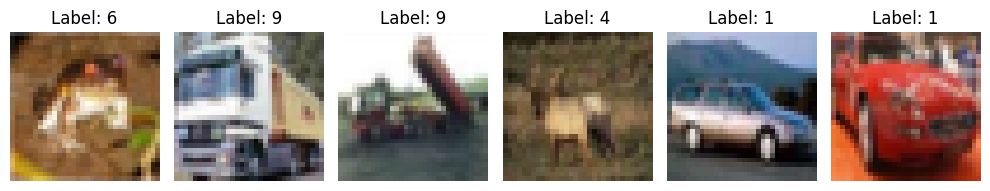

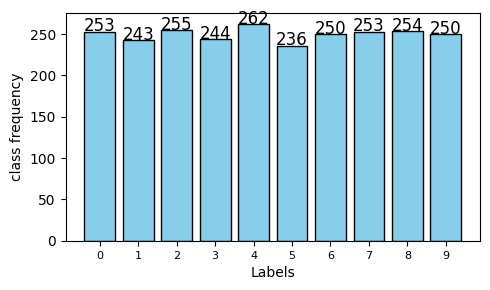

In [4]:
visualize_images(images, labels, 6) 
plot_class_frequencies(images, labels)

#### `Naive Approach` - Grayscale -> Flatten -> LwP with Euclidean / Mahalanobis Distance
* Note we working with 1st Training data set

In [5]:
## converting to grayscale
images = convert_to_grayscale(images)

# Flatten each 32x32 image to a 1024-dimensional vector
N = images.shape[0]
flattened_images = images.reshape(N, -1) 

model = LwP(n_prototypes=10)
model.fit(flattened_images, labels)

# loading eval dataset 1 -> grayscale -> flattening
X_eval, y_eval = load_data(1, "eval", "one")
X_eval = convert_to_grayscale(X_eval)
X_eval = X_eval.reshape(X_eval.shape[0], -1)

# predicting on it
    # - Euclidean Distance
predictions = model.predict(X_eval, name = "euclidean")
accuracy = np.mean(predictions == np.asarray(y_eval))
print(f'Accuracy with Euclidean Distance: {accuracy * 100:.2f}%')

    # - Mahalanobis Distance
predictions = model.predict(X_eval, name = "mahalanobis")
accuracy = np.mean(predictions == np.asarray(y_eval))
print(f'Accuracy with Mahalanobis Distance: {accuracy * 100:.2f}%')

Accuracy with Euclidean Distance: 23.80%
Accuracy with Mahalanobis Distance: 15.64%


#### `LwP_diff_cov` we have implemented this assuming different Gaussian Class Conditional for each class i.e Different Covariance Matrix but `LwP` assume same covariance matrix.

In [6]:
# LwP model with have only mahalanobis distance
model = LwP_diff_cov(n_prototypes=10)
model.fit(flattened_images, labels)

# predicting on it
predictions = model.predict(X_eval)
accuracy = np.mean(predictions == np.asarray(y_eval))
print(f'Accuracy on LwP_diff_cov: {accuracy * 100:.2f}%')

Accuracy on LwP_diff_cov: 9.80%


#### New Approach -> Extracting features using Neural Network

In [7]:
## save_extracted_feature()

## Above function assume `dataset` folder is present and save extracted features in the same directory as following Hierarchy

"""
extracted_feature
|  part_one_feature
|  |    eval_feature
|  |        - i_eval_feature.tar.pth  i ∈ [1, 2, ..., 10]
|  |    Train_feature
|  |        - {i}_train_feature.tar.pth i ∈ [1, 2, ..., 10]
|  |  
|  |
|  part_two_feture
|  |     eval_feature
|  |        - {i}_eval_feature.tar.pth  i ∈ [1, 2, ..., 10]
|  |     train_feature
|  |        - {i}_train_feature.tar.pth i ∈ [1, 2, ..., 10]
"""

""" 
* From now onwards we assume we have extracted_feature folder in the same directory that we have provided the google drive link
  or you can run it by yourself but will takes approximately ~ 30 mins.
* If we gonna generate new samples then we are going to extract features for it using `extract_feature function`.          """;


In [8]:
res = [[0] * 10 for _ in range(10)]

## Loading feature for training dataset 1
y = load_data(1, "train", "one", y_only = True)
X = load_features(1, "train", "one")

model = LwP(10)
model.fit(X, y)

## Loading Evaluation Features dataset 1
y_eval = load_data(1, "eval", "one", y_only = True)
X_eval = load_features(1, "eval", "one")

## Predicting
y_pred = model.predict(X_eval)
acc = np.mean(y_eval == y_pred)

# predicting on it
    # - Euclidean Distance
predictions = model.predict(X_eval, name = "euclidean")
accuracy = np.mean(predictions == np.asarray(y_eval))
print(f'Accuracy with Euclidean Distance: {accuracy * 100:.2f}%')

    # - Mahalanobis Distance
predictions = model.predict(X_eval, name = "mahalanobis")
accuracy = np.mean(predictions == np.asarray(y_eval))
print(f'Accuracy with Mahalanobis Distance: {accuracy * 100:.2f}%')

Accuracy with Euclidean Distance: 81.36%
Accuracy with Mahalanobis Distance: 85.36%


`Task 1.1` - D2 to D10 

Since Mahalanobis is Giving Best Acc Score therefore we are continuing with "Mahalanobis Distance"

In [9]:
## From Training dataset 2 predicting labels and updating it
for i in range(2, 11):
    print(f'Running {i}')
    X = load_features(i, 'train', 'one')
    y = model.predict(X)
    ## Updating LwP model on X, and predicte y labels
    model.update(X, y)

    for j in range(1, i + 1):
        y = load_data(j, 'eval', 'one', y_only=True)
        X = load_features(j, 'eval', 'one')
        y_pred = model.predict(X)
        acc = np.mean(y_pred == y)
        print(f'{acc * 100:.2f}', end = " | ")
    print()

Running 2
82.96 | 82.24 | 
Running 3
81.72 | 81.92 | 82.20 | 
Running 4
82.72 | 81.84 | 81.44 | 81.96 | 
Running 5
80.72 | 81.84 | 82.08 | 80.96 | 81.76 | 
Running 6
79.80 | 81.24 | 81.68 | 81.68 | 81.80 | 80.80 | 
Running 7
81.44 | 81.20 | 82.40 | 80.88 | 81.44 | 81.64 | 81.60 | 
Running 8
80.76 | 80.16 | 81.96 | 81.08 | 81.84 | 81.36 | 80.72 | 80.72 | 
Running 9
80.36 | 81.36 | 80.84 | 81.24 | 82.28 | 80.88 | 81.16 | 82.04 | 79.96 | 
Running 10
81.88 | 81.20 | 80.88 | 81.08 | 82.20 | 81.84 | 81.48 | 80.64 | 80.52 | 81.04 | 


In [ ]:
## Save this model trained on D1 to D10
# with open('best_model.pkl', 'wb') as f:
#      pickle.dump(model, f)

In [2]:
model = pickle.load(open('best_model.pkl', 'rb'))

##### Now `updating` and `predicting` for `D11` to `D20`.
##### `Note` - we only upadate our model on `top K confidence` samples.

In [3]:
model = pickle.load(open('best_model.pkl', 'rb')) ## Loading Model

for i in range(1, 11): # for part two
    print(f'Running {i}')

    X = load_features(i, 'train', 'two')

    X_opt, y_opt = model.top_k(X, 500)

    model.update(X_opt, y_opt, False)

    for j in range(1, 11):
        y = load_data(j, 'eval', 'one', y_only=True)
        X = load_features(j, 'eval', 'one')
        y_pred = model.predict(X, name= "euclidean")

        acc = np.mean(y_pred == y)
        print(f'{acc * 100:.2f}', end=' | ')

    for j in range(1, i + 1):
        y = load_data(j, 'eval', 'two', y_only=True)
        X = load_features(j, 'eval', 'two')
        y_pred = model.predict(X, name = "euclidean")

        acc = np.mean(y_pred == y)
        print(f'{acc * 100:.2f}', end=' | ')

    print()

Running 1
80.16 | 80.96 | 80.92 | 81.56 | 81.92 | 81.76 | 81.08 | 81.44 | 80.88 | 81.76 | 66.32 | 
Running 2
80.40 | 81.00 | 81.20 | 81.40 | 81.88 | 81.76 | 81.08 | 81.52 | 80.76 | 82.08 | 66.16 | 47.52 | 
Running 3
80.56 | 80.96 | 81.12 | 81.48 | 81.68 | 81.80 | 81.12 | 81.52 | 80.68 | 81.88 | 66.24 | 47.28 | 70.40 | 
Running 4
80.56 | 80.84 | 81.04 | 81.60 | 81.76 | 81.96 | 81.12 | 81.36 | 80.68 | 82.08 | 66.16 | 47.24 | 70.32 | 74.60 | 
Running 5
80.52 | 80.88 | 81.08 | 81.60 | 81.80 | 81.96 | 81.16 | 81.40 | 80.60 | 82.00 | 66.20 | 47.08 | 70.44 | 74.56 | 80.60 | 
Running 6
80.56 | 80.76 | 81.08 | 81.56 | 81.72 | 81.96 | 81.12 | 81.24 | 80.52 | 82.16 | 66.24 | 47.16 | 70.40 | 74.48 | 80.60 | 67.16 | 
Running 7
80.60 | 80.84 | 81.24 | 81.56 | 81.68 | 82.00 | 81.32 | 81.28 | 80.80 | 82.20 | 66.36 | 46.88 | 70.32 | 74.44 | 80.44 | 67.36 | 72.52 | 
Running 8
80.52 | 80.76 | 81.28 | 81.56 | 81.68 | 81.96 | 81.24 | 81.08 | 80.80 | 82.32 | 66.76 | 47.16 | 70.36 | 74.56 | 80.72 | 67.64 | 7

`BEYOND top-k`

##### Generating Pseudo Samples of Training dataset part 1 i.e will train LwP model on (2500 x 2, 32, 32, 3)

In [9]:
clear_cache()

images, labels = load_data(1, 'train', 'one')

## Generating Samples
X_gen, y_gen = generate_samples(images, labels)

clear_cache()

## Fitting the model and predicting
model = LwP(10)
X_gen = extract_features(X_gen, 1)
model.fit(X_gen, y_gen)
X_eval = load_features(1, "eval","one")
y_eval = load_data(1, "eval", "one", y_only=True)
y_pred = model.predict(X_eval)
print(f'Accuracy with Mahalanobis Distance: {accuracy * 100:.2f}%')

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 0 has a total capacity of 4.00 GiB of which 0 bytes is free. 4.00 GiB allowed; Of the allocated memory 4.03 GiB is allocated by PyTorch, and 79.63 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

#### Training on D2 to D10 by generating samples -> (5000, 32, 32, 3) for each dataset

In [ ]:
for i in range(2, 11):
    print(f'Running {i}')

    X = load_features(i, 'train', 'one')
    im = load_data(i, 'train', 'one')

    X_opt, y_opt = model.top_k(X, 2500, indices=True) # doubling sampple size to better train LwP
    X_new = np.asanyarray([im[i] for i in X_opt]) # convert to np.ndarray
    X_new = ((torch.tensor(X_new)).float() / 255.0).permute(0, 3, 1, 2).cuda() # convert to B, C, W, H
    X_gen, y_gen = sampler().generate(X_new, torch.tensor(y_opt), 1) # new samples with some small noise
    X_gen = extract_features(X_gen) # use ResNet on these new samples

    # X_new, y_new = model2.top_k(X_new, 10*(i - 1))
    if (i != 1): model.update(X_gen, y_gen, True) # except the first dataset, update the model

    for j in range(1, i + 1):
        y = load_data(j, 'eval', 'one', y_only=True)
        X = load_features(j, 'eval', 'one')
        y_pred = model.predict(X)

        acc = np.mean(y_pred == y)
        # res[i - 1][j - 1] = f'{acc * 100:.2f}'
        print(f'{acc * 100:.2f}', end=' | ')

    print()

In [ ]:
with open('model.pkl', 'wb') as f:
     pickle.dump(model, f)

In [ ]:
model2 = pickle.load(open('model.pkl', 'rb'))

In [ ]:
model2 = pickle.load(open('model.pkl', 'rb'))

for i in range(1, 11): # for part two
    print(f'Running {i}')

    X = load_features(i, 'train', 'two')
    im = load_data(i, 'train', 'two')

    X_opt, y_opt = model2.top_k(X, 500, indices=False)
    # X_new = np.asanyarray([im[i] for i in X_opt])
    # X_new = ((torch.tensor(X_new)).float() / 255.0).permute(0, 3, 1, 2).cuda()
    # X_gen, y_gen = sampler().generate(X_new, torch.tensor(y_opt), 1)
    
    # X_gen = extract_features(X_gen)

    model2.update(X_opt, y_opt, False)

    for j in range(1, 11):
        y = load_data(j, 'eval', 'one', y_only=True)
        X = load_features(j, 'eval', 'one')
        y_pred = model2.predict(X)

        acc = np.mean(y_pred == y)
        print(f'{acc * 100:.2f}', end=' | ')

    for j in range(1, i + 1):
        y = load_data(j, 'eval', 'two', y_only=True)
        X = load_features(j, 'eval', 'two')
        y_pred = model2.predict(X)

        acc = np.mean(y_pred == y)
        print(f'{acc * 100:.2f}', end=' | ')

    print()

###

In [ ]:
model2 = pickle.load(open('model.pkl', 'rb'))

for i in range(1, 11): # for part two
    print(f'Running {i}')

    X = load_features(i, 'train', 'two')
    im = load_data(i, 'train', 'two')

    X_opt, y_opt = model2.top_k(X, 1250, indices=True)
    X_new = np.asanyarray([im[i] for i in X_opt])
    X_new = ((torch.tensor(X_new)).float() / 255.0).permute(0, 3, 1, 2).cuda()
    X_gen, y_gen = sampler().generate(X_new, torch.tensor(y_opt), 1)
    
    X_gen = extract_features(X_gen)

    model2.update(X_gen, y_gen, False)

    for j in range(1, 11):
        y = load_data(j, 'eval', 'one', y_only=True)
        X = load_features(j, 'eval', 'one')
        y_pred = model2.predict(X)

        acc = np.mean(y_pred == y)
        print(f'{acc * 100:.2f}', end=' | ')

    for j in range(1, i + 1):
        y = load_data(j, 'eval', 'two', y_only=True)
        X = load_features(j, 'eval', 'two')
        y_pred = model2.predict(X)

        acc = np.mean(y_pred == y)
        print(f'{acc * 100:.2f}', end=' | ')

    print()

In [ ]:
model2 = pickle.load(open('model.pkl', 'rb'))

for i in range(1, 11): # for part two
    print(f'Running {i}')

    X = load_features(i, 'train', 'two')
    im = load_data(i, 'train', 'two')

    X_opt, y_opt = model2.top_k(X, 1250, indices=True)
    X_new = np.asanyarray([im[i] for i in X_opt])
    X_new = ((torch.tensor(X_new)).float() / 255.0).permute(0, 3, 1, 2).cuda()
    X_gen, y_gen = sampler().generate(X_new, torch.tensor(y_opt), 1)
    
    X_gen = extract_features(X_gen)

    model2.update(X_gen, y_gen, False)

    for j in range(1, 11):
        y = load_data(j, 'eval', 'one', y_only=True)
        X = load_features(j, 'eval', 'one')
        y_pred = model2.predict(X, name='euc')

        acc = np.mean(y_pred == y)
        print(f'{acc * 100:.2f}', end=' | ')

    for j in range(1, i + 1):
        y = load_data(j, 'eval', 'two', y_only=True)
        X = load_features(j, 'eval', 'two')
        y_pred = model2.predict(X, name='euc')

        acc = np.mean(y_pred == y)
        print(f'{acc * 100:.2f}', end=' | ')

    print()

In [2]:
model2 = pickle.load(open('best_model.pkl', 'rb'))

for i in range(1, 11): # for part two
    print(f'Running {i}')

    X = load_features(i, 'train', 'two')
    im = load_data(i, 'train', 'two')

    X_opt_indices, y_opt = model2.top_k(X, 500, indices=True)
    X_opt = np.asanyarray([X[i] for i in range(len(X)) if i in X_opt_indices])
    model_cosine = LwP(10)
    model_cosine.fit(X_opt, y_opt)
    
    # print(X_opt.shape, y_opt.shape, 'opt')

    X_unlabeled = np.asanyarray([X[i] for i in range(len(X)) if i not in X_opt])
    X_cosine_indices, y_cosine = model_cosine.cosine_top_k(X_unlabeled, 125, indices=True)
    X_cosine = np.asanyarray([X[i] for i in range(len(X)) if i in X_cosine_indices])

    # print(X_cosine.shape, y_cosine.shape, 'cosine')

    X_final_unlabeled = np.asanyarray([X[i] for i in range(len(X)) if i not in X_cosine_indices and i not in X_opt_indices])

    knn_classifier = KNN(43) # hyperparam
    labeled_X, labeled_y = np.concatenate((X_opt, X_cosine)), np.concatenate((y_opt, y_cosine))
    knn_classifier.fit(labeled_X, labeled_y)
    last_labels = knn_classifier.predict(X_final_unlabeled)


    model2.update(np.concatenate((labeled_X, X_final_unlabeled)), np.concatenate((labeled_y, last_labels)))
    """
    // TODO
    [X] implement cosine sim
    [X] take cosine sim of indices NOT in X_opt with model_new.prototypes
    [X] top 50% of this (hyperparam)
    [X] ^ these are labeled
    [X] use KNN here to label remaining train data
    [X] don't touch eval dataset
    [X] call model.update on final labeled samples
    [ ] debug
    """

    # X_new = np.asanyarray([im[i] for i in X_opt])
    # X_new = ((torch.tensor(X_new)).float() / 255.0).permute(0, 3, 1, 2).cuda()
    # X_gen, y_gen = sampler().generate(X_new, torch.tensor(y_opt), 1)
    
    # X_gen = extract_features(X_gen)

    # model2.update(X_gen, y_gen, False)

    for j in range(1, 11):
        y = load_data(j, 'eval', 'one', y_only=True)
        X = load_features(j, 'eval', 'one')
        y_pred = model2.predict(X)

        acc = np.mean(y_pred == y)
        print(f'{acc * 100:.2f}', end=' | ')

    for j in range(1, i + 1):
        y = load_data(j, 'eval', 'two', y_only=True)
        X = load_features(j, 'eval', 'two')
        y_pred = model2.predict(X)

        acc = np.mean(y_pred == y)
        print(f'{acc * 100:.2f}', end=' | ')

    print()

Running 1
76.60 | 77.20 | 77.12 | 77.36 | 77.04 | 76.92 | 77.16 | 75.76 | 76.88 | 77.24 | 34.64 | 
Running 2


: 

In [4]:
model2 = pickle.load(open('model.pkl', 'rb'))

for i in range(1, 11): # for part two
    print(f'Running {i}')

    X = load_features(i, 'train', 'two')
    im = load_data(i, 'train', 'two')

    X_opt_indices, y_opt = model2.top_k(X, 1250, indices=True)
    X_opt = np.asanyarray([im[i] for i in X_opt_indices])
    X_opt = ((torch.tensor(X_opt).float()) / 255.0).permute(0, 3, 1, 2).cuda()

    X_opt, y_opt = sampler().generate(X_opt, torch.tensor(y_opt), 1)
    X_opt = X_opt.permute(0, 2, 3, 1).squeeze(0).cpu().detach().numpy()
    X_opt = extract_features(X_opt)

    model_cosine = LwP(10)
    model_cosine.fit(X_opt, y_opt)
    
    # print(X_opt.shape, y_opt.shape, 'opt')

    X_unlabeled = np.asanyarray([X[i] for i in range(len(X)) if i not in X_opt])
    X_cosine_indices, y_cosine = model_cosine.cosine_top_k(X_unlabeled, 125, indices=True)
    X_cosine = np.asanyarray([X[i] for i in range(len(X)) if i in X_cosine_indices])

    # print(X_cosine.shape, y_cosine.shape, 'cosine')

    X_final_unlabeled = np.asanyarray([X[i] for i in range(len(X)) if i not in X_cosine_indices and i not in X_opt_indices])

    knn_classifier = KNN(43) # hyperparam
    labeled_X, labeled_y = np.concatenate((X_opt, X_cosine)), np.concatenate((y_opt, y_cosine))
    knn_classifier.fit(labeled_X, labeled_y)
    last_labels = knn_classifier.predict(X_final_unlabeled)

    model2.update(np.concatenate((labeled_X, X_final_unlabeled)), np.concatenate((labeled_y, last_labels)))
    """
    // TODO
    [X] implement cosine sim
    [X] take cosine sim of indices NOT in X_opt with model_new.prototypes
    [X] top 50% of this (hyperparam)
    [X] ^ these are labeled
    [X] use KNN here to label remaining train data
    [X] don't touch eval dataset
    [X] call model.update on final labeled samples
    [ ] debug
    """

    # X_new = np.asanyarray([im[i] for i in X_opt])
    # X_new = ((torch.tensor(X_new)).float() / 255.0).permute(0, 3, 1, 2).cuda()
    # X_gen, y_gen = sampler().generate(X_new, torch.tensor(y_opt), 1)
    
    # X_gen = extract_features(X_gen)

    # model2.update(X_gen, y_gen, False)

    for j in range(1, 11):
        y = load_data(j, 'eval', 'one', y_only=True)
        X = load_features(j, 'eval', 'one')
        y_pred = model2.predict(X)

        acc = np.mean(y_pred == y)
        print(f'{acc * 100:.2f}', end=' | ')

    for j in range(1, i + 1):
        y = load_data(j, 'eval', 'two', y_only=True)
        X = load_features(j, 'eval', 'two')
        y_pred = model2.predict(X)

        acc = np.mean(y_pred == y)
        print(f'{acc * 100:.2f}', end=' | ')

    print()

Running 1


: 